# ERV differentiation

Two main research questions:
1. Are ERV's differentially expressed in SCC versus AC?
2. Are ERV's involved in immune surveillance in lung cancer

We have to 
* identify ERV's in Adeno and SCC
* identify granzy mand perforin expression per subtype
* identify IFN gene expression per subtype
* silencing of ERV by methylation in normal tissue



In [93]:
import vaex as vx
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import scipy as sc
from scipy.interpolate import PchipInterpolator as minterp
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt

import os
import sys
import re
from numba import jit
from collections import Counter
from collections import namedtuple

In [94]:
max_nans_perc = 0.1

In [95]:
os.chdir('/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/')

In [96]:
dd = {}
dd['RNAex'] = vx.open('Lung_GeneExpression.hdf5')
dd['mutation'] = vx.open('Lung_Mutation.hdf5')
dd['methylation'] = vx.open('Lung_Methylation.hdf5')
dd['methylation_meta'] = vx.open('HumanMethylation450_meta.hdf5')
dd['CNV'] = vx.open('Lung_CNV.hdf5')

meta = pd.read_csv('Lung_Phenotype_Metadata.txt', sep='\t')
meta = meta.loc[~pd.isna(meta.Diagnosis)]
meta = meta[~meta.SampleID.duplicated(keep='last')]
meta.set_index('SampleID', inplace=True)

In [97]:
meta.columns

Index(['PatientID', 'Diagnosis', 'Sample Type', 'Gender', 'Ethnicity',
       'Age At Diagnosis (Days)', 'Age At Diagnosis (Years)', 'Vital Status ',
       'Overall Survival Status', 'Time To Overall Survival (Days)',
       'Time To Overall Survival From Treatment (Days)', 'Relapse Status',
       'Time To Relapse From Diagnosis (Days)', 'Event Status',
       'Time To Event From Diagnosis (Days)', 'Karnofsky Score',
       'Smoking Status', 'Pack Years', 'Histological Type', 'Morphology',
       'Site Of Resection', 'Tumor Location', 'Anatomic Location In Lung',
       'Tumor Stage', 'T-stage', 'N-stage', 'M-stage', 'R-stage',
       'Cancer Status After Resection', 'Drug Therapy Type', 'Drug Name',
       'Time To Drug Therapy (Days)', 'Radiation Therapy',
       'Time To Radiation Therapy (Days)', 'Reponse To Therapy',
       'Time To Therapy (Days)', 'Therapy Ongoing', 'New Tumor Event',
       'New Tumor Event Type', 'Time To New Tumor Event (Days)'],
      dtype='object')

In [98]:
erv_genes = [_gene for _gene in dd['RNAex'].Gene.unique() if 'ERV' in _gene]
erv_genes += [_gene for _gene in dd['methylation'].Gene.unique() if 'ERV' in _gene]
erv_genes = list(set(erv_genes))

In [99]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5942792/
neutro_gene_list = ['DEFA4', 'DEFA3', 'MMP8', 'CEACAM6', 'CEACAM8', 'LTF', 'MPO', 'ARG1', 'MSHA3']
neutro_genes = [_gene for _gene in dd['RNAex'].Gene.unique() if _gene in neutro_gene_list]
neutro_genes += [_gene for _gene in dd['methylation'].Gene.unique() if _gene in neutro_gene_list]
neutro_genes = list(set(neutro_genes))
# https://www.jimmunol.org/content/175/12/7837.long
t_cell_gene_list = ['CXCR5', 'CXCR3', 'CCR3', 'CCR5', 'CRTH2', 'CCR7']
tcell_genes = [_gene for _gene in dd['RNAex'].Gene.unique() if _gene in t_cell_gene_list]
tcell_genes += [_gene for _gene in dd['methylation'].Gene.unique() if _gene in t_cell_gene_list]
tcell_genes = list(set(tcell_genes))

In [100]:
gene_list = erv_genes+neutro_genes+tcell_genes

In [101]:
df_erv = {}
for _key in dd:  
    d = dd[_key]
    if 'Gene' in d.columns:
        temps = []
        for _gene in gene_list:
            temps.append(d[d.Gene == _gene].to_pandas_df())            
        df_erv[_key] = pd.concat(temps, axis=0)
        
var_cols = {}

In [102]:
probe_map = df_erv['methylation'][['probeID', 'Chr', 'Start', 'Stop', 'Strand', 'Gene', 'Relation_CpG_Island']].reset_index().drop('index', axis=1)
df_erv['methylation'] = df_erv['methylation'].drop(['Chr', 'Start', 'Stop', 'Strand', 'Gene', 'Relation_CpG_Island'], axis=1)
df_erv['methylation'].set_index('probeID', inplace=True)
df_erv['methylation'] = df_erv['methylation'].transpose()

max_nans = int(max_nans_perc*df_erv['methylation'].shape[0])
df_erv['methylation'].index = [re.sub(r'_', '-', _old_key) for _old_key in df_erv['methylation'].index.tolist()]
df_erv['methylation'] = df_erv['methylation'].loc[:, df_erv['methylation'].columns[df_erv['methylation'].isna().sum()\
                                                                                   <max_nans].tolist()]
var_cols['methylation'] = df_erv['methylation'].columns.tolist()

In [103]:
exp_map = df_erv['RNAex'][['Gene', 'Chr', 'Start', 'Stop', 'Strand']].reset_index().drop('index', axis=1)
df_erv['RNAex'] = df_erv['RNAex'].drop(['Chr', 'Start', 'Stop', 'Strand'], axis=1)
df_erv['RNAex'].set_index('Gene', inplace=True)
df_erv['RNAex'] = df_erv['RNAex'].transpose()

max_nans = int(max_nans_perc*df_erv['RNAex'].shape[0])
df_erv['RNAex'].index = [re.sub(r'_', '-', _old_key) for _old_key in df_erv['RNAex'].index.tolist()]
df_erv['RNAex'] = df_erv['RNAex'].loc[:, df_erv['RNAex'].columns[df_erv['RNAex'].isna().sum()\
                                                                                   <max_nans].tolist()]
var_cols['RNAex'] = df_erv['RNAex'].columns.tolist()

In [104]:
df_erv['mutation'] = df_erv['mutation'][df_erv['mutation'].Effect!='upstream_gene_variant']
mut_map = df_erv['mutation'][['Amino_Acid_Change', 'Gene', 'Chr', 'Start', 'Stop', 'Ref', 'Alt']].reset_index().drop('index', axis=1)
df_erv['mutation'] = df_erv['mutation'].drop(['Gene', 'Chr', 'Start', 'Stop', 'Ref', 'Alt'], axis=1)
df_erv['mutation'] = df_erv['mutation'].reset_index().drop('index', axis=1)
df_erv['mutation'] = df_erv['mutation'].rename(index=str, columns={'Sample_ID': 'SampleID'})
df_erv['mutation'].set_index('SampleID', inplace=True)
var_cols['mutation'] = df_erv['mutation'].columns.tolist()

In [105]:
cnv_map = df_erv['CNV'][['Gene', 'Chr', 'Start', 'Stop', 'Strand']]
df_erv['CNV'] = df_erv['CNV'].drop(['Chr', 'Start', 'Stop', 'Strand'], axis=1)
df_erv['CNV'] = df_erv['CNV'].set_index('Gene')
df_erv['CNV'] = df_erv['CNV'].transpose()
df_erv['CNV'].index = [re.sub(r'_', '-', _old_key) for _old_key in df_erv['CNV'].index.tolist()]
var_cols['CNV'] = df_erv['CNV'].columns.tolist()

In [107]:
meta_cols = ['Gender', 'Diagnosis', 'Age At Diagnosis (Years)', 'Overall Survival Status',
                                  'Pack Years', 'Smoking Status']
meta_cols = meta_cols + ['New Tumor Event', 'Radiation Therapy', 'Reponse To Therapy', 'Drug Therapy Type']
for _key in df_erv:
    df_erv[_key] = df_erv[_key].join(meta[meta_cols])

In [108]:
df_erv.keys()

dict_keys(['RNAex', 'mutation', 'methylation', 'CNV'])

## Check class/survival differentiation per feature

In [109]:
"""
     Information change: 
        * Kullback-Leibler divergence (have to make same number of bins)
        * cross-entropy
        * Shannon entropy change
"""
@jit
def _information_change(v1, v2, ent_type = 'kl', bin_type='fixed', num_bins=25):
    '''
    v1: vector one
    v2: vector two
    ent_type : kl, shannon, cross
    bin_type : auto, fixed
    num_bins : non-zero positive integer
    
    return entropy difference
    '''
    # get bins
    num_bins = num_bins if bin_type=='fixed' else bin_type
    v1bins = np.histogram(v1, density=True, bins=num_bins)
    v2bins = np.histogram(v2, density=True, bins=num_bins)
    
    ent1 = -np.sum(v1bins[0]*np.log2(v1bins[0]))
    ent2 = -np.sum(v2bins[0]*np.log2(v2bins[0]))    
    
    log2v1 = np.log2(v1bins[0])
    log2v2 = np.log2(v2bins[0])
    
    if ent_type == 'shannon':
        return 2*np.abs(ent1-ent2)/(np.abs(ent1)+np.abs(ent2))
    elif ent_type == 'cross':
        cross1 = -np.sum(v1bins[0]*log2v2)
        cross2 = -np.sum(v2bins[0]*log2v1)        
        return 2*np.max([np.abs(cross1),np.abs(cross2)])/(np.abs(ent1)+np.abs(ent2))
    elif ent_type == 'kl':
        return 2*np.max([np.abs(np.sum(v1bins[0]*(log2v1-log2v2))),
                         np.abs(np.sum(v2bins[0]*(log2v2-log2v1)))])/(np.abs(ent1)+np.abs(ent2))

In [110]:
@jit
def _skewness(x, logscale=False, bound=False, scale=1000, sample=False, bias=True):
    '''
    x : array(N,1)
    return skewness
    '''
    std = np.std(x)
    mu = np.mean(x)
    N = x.shape[0]
    val = np.sum(np.power(x-mu, 3))/np.power(std, 3)
    if sample==False:
        if bound==False:
            if logscale==False:
                return val
            else:
                return np.log10(np.abs(val))*np.sign(val)
        else:
            return np.tanh(val/scale)
    else:
        return stats.skew(x, bias=bias)

@jit
def _kurtosis(x, logscale=False, sample=False, bias=True):            
    std = np.std(x)
    mu = np.mean(x) 
    val = np.sum(np.power(x-mu, 4))/np.power(std, 4)
    if sample==False:
        if logscale==False:
            return val
        else:
            return np.log10(np.abs(val))*np.sign(val)
    else:
        return stats.kurtosis(x, bias=bias, nan_policy='omit')

@jit
def _stanmom(x, mom=3, logscale=False, mutype=0):
    # mom : 3 is skewness, 4 is kurtosis
    std = np.std(x)
    if mutype==0:
        mu = np.mean(x)
    else:
        mu = np.median(x)
    val = np.sum(np.power(x-mu, mom))/np.power(std, mom)
    if logscale==False:
        return val
    else:
        return np.log10(np.abs(val))*np.sign(val)
    
from unidip import UniDip  
import unidip.dip as dip
def _multimodality(x, method='hartigan'):
    x = np.msort(x)
    # multi-modality can be extracted from the number of inflection points on a q-q plot 
    if method=='hartigan':
        return len(UniDip(x).run())
    
def _qq(x, cdist=stats.norm, minkowski=2, plot=None):
    # surface area,max_slope,min_slope
    vref, v = stats.probplot(x, dist=cdist, plot=plot, fit=False)
    
    dist_cos = sc.spatial.distance.cosine(vref, v)
    dist_euc = sc.spatial.distance.minkowski(vref, v, p=minkowski)
    mm0 = np.max(vref)-np.min(vref)
    mm1 = np.max(v)-np.min(v)
    nsam  = mm0*mm1*0.5
    asam = 0.5*np.sum(np.diff(vref)*(v[:-1]+v[1:]))
    # skewed metric
    # positive: left-skewed, negative: right-skewed
    sm = (asam-nsam)/nsam 
    return dist_cos, dist_euc/mm0/mm1, sm
 
def _qq2(x1, x2, qbins=15, plot=False, minkowski=2):
    # identify left-skewness, right-skewness, under-dispersed, over-dispersed data
    # see e.g. http://www.ucd.ie/ecomodel/Resources/QQplots_WebVersion.html
    # surface area,max_slope,min_slope
    
    qbins = np.min([qbins, np.min([len(x1), len(x2)])])
    qstep = np.max([1, int(100/qbins)])
    
    perc1 = np.percentile(x1, q=np.arange(0, 100, qstep))
    perc2 = np.percentile(x2, q=np.arange(0, 100, qstep))
    
    if plot:
        plt.plot(perc1, perc2)
        plt.plot([np.min(perc1), np.max(perc1)],[np.min(perc2), np.max(perc2)])
        plt.title('Q-Q')  
        plt.xlabel('q-'+meta_vals[0])
        plt.ylabel('q-'+meta_vals[1])
    
    dist_cos = sc.spatial.distance.cosine(perc1, perc2)
    dist_euc = sc.spatial.distance.minkowski(perc1, perc2, p=minkowski)
    mm0 = np.max(perc1)-np.min(perc1)
    mm1 = np.max(perc2)-np.min(perc2)
    nsam  = mm0*mm1*0.5
    asam = 0.5*np.sum(np.diff(perc1)*(perc2[:-1]+perc2[1:]))
    # skewed metric
    # positive: left-skewed, negative: right-skewed
    sm = (asam-nsam)/nsam 
    return dist_cos, dist_euc/mm0/mm1, sm
    

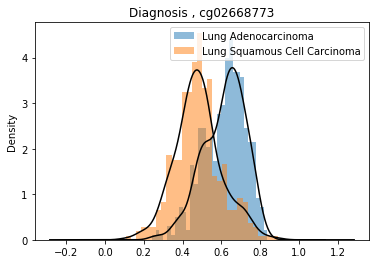

In [111]:
i=60
meta_col = 'Diagnosis' # 
meta_vals = df_erv['methylation'][meta_col].unique().tolist()
val_series = []
for _meta_col_val in meta_vals:
    if pd.isna(_meta_col_val)==False:
        x = df_erv['methylation'].loc[df_erv['methylation'][meta_col]==_meta_col_val, var_cols['methylation'][i]]
        x.plot.hist(bins=30, alpha=0.5, density=True, label=_meta_col_val)
        x.plot.kde(color='black', label='')
        val_series.append(x)
plt.title(meta_col+' , '+var_cols['methylation'][i])
plt.legend()


In [112]:
@jit
def _cdf(x,bin_size=5):
    x = np.sort(x)
    c = len(x)
    res, _res= np.empty((0, 2)), np.empty((0,2))
    for i in range(bin_size, c):
        if i%bin_size==0:
            _res = np.array([i/c, np.median(x[(i-bin_size):i])])
            res = np.append(res, [_res], axis=0)    
    return res
# np.asarray([[i/c, np.median(x[(i-bin_size):i])] for i in range(bin_size, c) if i%bin_size==0])

@jit
def _cdfcoeff(x, bin_size=5):
    # better to take out the creation of the cdf and split the function (_cdf, _cdfcoeff)
    lt = _cdf(x, bin_size=bin_size)
    xmm = x.max()-x.min()
    diff1 = np.diff(lt[:,1])*lt[:-1, 0]
    diff1[0:1] = 0  
    diff2 = np.diff(diff1)
    diff2[0:1] = 0 
    diff2 = diff2*lt[:-2, 0]

    # modus is peak in f'' followed by valley  in f''
    xmmp = xmm**4
    tv, td = (diff2[0:-1]-diff2[1:]), (np.sign(diff2[0:-1])-np.sign(diff2[1:]))
    xrelcount, xbumpmean, xdiffmean, xdiffvar = (td>0).sum()/(lt.shape[0]-1), tv[tv>0].mean()/xmmp, diff1.mean()/xmmp, diff1.std()/xmmp
    
    return xrelcount, xbumpmean, xdiffmean, xdiffvar

@jit
def _interp(xinter, yinter, xextra):
    return minterp(xinter, yinter, axis=0, extrapolate=True)(xextra)

@jit
def _cdf_distanceB(x1, x2, bin_size=5, minkowsi=1):
    '''
     takes the Minkowski distance between the ecdf's and the Russell-Rao distance of the bump indicators
    ''' 
    lt1 = _cdf(x1, bin_size=bin_size)
    lt2 = _cdf(x2, bin_size=bin_size)

    l1 = _interp(xinter=lt1[:,0], yinter=lt1[:,1], xextra=lt1[:,0])
    l2 = _interp(xinter=lt2[:,0], yinter=lt2[:,1], xextra=lt1[:,0])

    l1diff = np.diff(l1)
    l2diff = np.diff(l2)

    l1diff2 = np.diff(l1diff)
    l2diff2 = np.diff(l2diff)

    l1diff2sign = np.sign(l1diff2)
    l2diff2sign = np.sign(l2diff2)

    l1bump = l1diff2sign[0:-1]-l1diff2sign[1:]
    l2bump = l2diff2sign[0:-1]-l2diff2sign[1:] 

    d1 = sc.spatial.distance.minkowski(l1, l2, p=minkowsi)*sc.spatial.distance.russellrao(l1bump, l2bump)
    d2 = sc.spatial.distance.minkowski(l1diff, l2diff, p=minkowsi)*sc.spatial.distance.russellrao(l1bump, l2bump)
    d3 = sc.spatial.distance.russellrao(l1bump, l2bump)   
    return d1,d2,d3

@jit
def _cdf_distanceG(x1, x2, bin_size=15):
    # also see PhD-thesis Gabriel Martos Venturini, Statistical distance and probability metrics for multivariate data..etc., June 2015 Uni. Carlos III de Madrid
    # https://core.ac.uk/download/pdf/30276753.pdf
    '''
     Basically the l1-difference between the distributions
    '''
    lt1 = _cdf(x1, bin_size=bin_size)
    lt2 = _cdf(x2, bin_size=bin_size)

    l1 = _interp(xinter=lt1[:,0], yinter=lt1[:,1], xextra=lt1[:,0])
    l2 = _interp(xinter=lt2[:,0], yinter=lt2[:,1], xextra=lt1[:,0])    
    
    c = len(l1)
    
    diffSumabsAgg= np.sum(lt1[:,0]*(np.abs(l2-l1)))/c
    diffSumAgg = np.sum(lt1[:,0]*(l2-l1))/c
    return diffSumAgg, diffSumabsAgg



In [113]:
'''
Univariated intra-distribution characterisations:
    * [x] skewness
    * [x] kurtosis
    * multimodality
    * normality test
        * [x] q-qnorm metrics
        * Shapiro-Wilk
        * Anderson-Darling
        * Crámer-von-Mises criterion
        * Jarque-Bera
        * Gel-Gastwirth test
        * Bonett-Seier test
'''



'\nUnivariated intra-distribution characterisations:\n    * [x] skewness\n    * [x] kurtosis\n    * multimodality\n    * normality test\n        * [x] q-qnorm metrics\n        * Shapiro-Wilk\n        * Anderson-Darling\n        * Crámer-von-Mises criterion\n        * Jarque-Bera\n        * Gel-Gastwirth test\n        * Bonett-Seier test\n'

In [114]:
'''
Univariate inter-distribution distance:
        * Delta skewness
        * Delta kurtosis
        * Delta Normality test  (Shapiro-Wilk, Anderson-Darling)      
        * Kolmogorov-Smirnov (also normality test)
        * Cramér–von Mises criterion
        * Pearson's chi-squared test (only if all vars are binned and categorised)
        * Kuiper's test
        * Mann-Whitney U
        * Kruskall Wallis
        * nth-Wasserstein
        * FDR-BH-ANOVA
        * total variation distance
        * Hellinger distance
        * Bhattacharyya distance
        * [x] q-q distance
        * [x] CDF distance 
'''




"\nUnivariate inter-distribution distance:\n        * Delta skewness\n        * Delta kurtosis\n        * Delta Normality test  (Shapiro-Wilk, Anderson-Darling)      \n        * Kolmogorov-Smirnov (also normality test)\n        * Cramér–von Mises criterion\n        * Pearson's chi-squared test (only if all vars are binned and categorised)\n        * Kuiper's test\n        * Mann-Whitney U\n        * Kruskall Wallis\n        * nth-Wasserstein\n        * FDR-BH-ANOVA\n        * total variation distance\n        * Hellinger distance\n        * Bhattacharyya distance\n        * [x] q-q distance\n        * [x] CDF distance \n"

In [115]:
'''
    similarity -> dissimilarity:
    * d = 1 - s
    * d = sqrt(s(x,x)+s(y,y)-2s(x,y))
    * d= -log(s(x,y))
'''

'''
    dissimilarity -> similarity:
    * s = exp(-d(x,y)/sigma)
    * s = 1/(1+d(x,y))
    * s = 1/2*(d^2(x,c) + d^2(y,c)-d^2(x,y))
    
'''

'\n    dissimilarity -> similarity:\n    * s = exp(-d(x,y)/sigma)\n    * s = 1/(1+d(x,y))\n    * s = 1/2*(d^2(x,c) + d^2(y,c)-d^2(x,y))\n    \n'

In [116]:
'''
Pairwise distance:
    * Manhattan distance (only if all vars are binned and categorised)
    * Euclidean distance
    * Pearson  distance 
    * Kendall distance 
    * Spearman distance
    * 1-Cosine distance (pseudometric)
    * Mahalanobis distance
'''

'\nPairwise distance:\n    * Manhattan distance (only if all vars are binned and categorised)\n    * Euclidean distance\n    * Pearson  distance \n    * Kendall distance \n    * Spearman distance\n    * 1-Cosine distance (pseudometric)\n    * Mahalanobis distance\n'

In [117]:
# get feature-feature similarity



# get sample-sample similarity



## make N s-s-s bins 


In [118]:
# what combination of dimensions makes samples from different target groups most dissimilar?

## Check class/survival differentiation per feature combination 

## Check differentiation class/survival with/without ERV mutations

## Check activation of neutrofil/T-cell genes in relation to efficacy of immunotherapy

In [176]:
result_map = {'Complete Remission/Response': 1, 
              'Stable Disease': 0, 
              'Progressive Disease': 0,
              'Partial Remission/Response': 1}

neutro_probes = probe_map.loc[probe_map.Gene.isin(neutro_gene_list), 'probeID'].unique().tolist()
tcell_probes = probe_map.loc[probe_map.Gene.isin(tcell_genes), 'probeID'].unique().tolist()
erv_probes = probe_map.loc[probe_map.Gene.isin(erv_genes), 'probeID'].unique().tolist()

neutro_probes  = set(neutro_probes) & set(df_erv['methylation'].columns.tolist())
tcell_probes = set(tcell_probes) & set(df_erv['methylation'].columns.tolist())
erv_probes = set(erv_probes) & set(df_erv['methylation'].columns.tolist())
df_erv['methylation']['RTT'] = df_erv['methylation']['Reponse To Therapy'].map(result_map)

neutro_rna =  set(neutro_gene_list) & set(df_erv['RNAex'].columns.tolist())
tcell_rna = set(tcell_genes) & set(df_erv['RNAex'].columns.tolist())
erv_rna = set(erv_genes) & set(df_erv['RNAex'].columns.tolist())

df_erv['RNAex']['RTT'] = df_erv['RNAex']['Reponse To Therapy'].map(result_map)

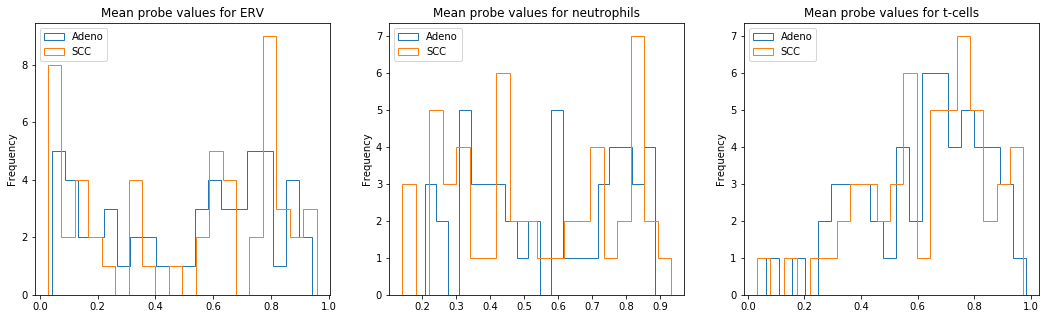

In [169]:
fig, ax = plt.subplots(ncols=3, figsize=(18,5))
df_erv['methylation'].loc[df_erv['methylation'].Diagnosis=='Lung Adenocarcinoma', erv_probes]\
                                                    .mean(axis=0).plot.hist(bins=20, histtype='step', ax=ax[0], label='Adeno')
df_erv['methylation'].loc[df_erv['methylation'].Diagnosis=='Lung Squamous Cell Carcinoma', erv_probes]\
                                                    .mean(axis=0).plot.hist(bins=20, histtype='step', ax=ax[0], label='SCC')

df_erv['methylation'].loc[df_erv['methylation'].Diagnosis=='Lung Adenocarcinoma', neutro_probes]\
                                                    .mean(axis=0).plot.hist(bins=20, histtype='step', ax=ax[1], label='Adeno')
df_erv['methylation'].loc[df_erv['methylation'].Diagnosis=='Lung Squamous Cell Carcinoma', neutro_probes]\
                                                    .mean(axis=0).plot.hist(bins=20, histtype='step', ax=ax[1], label='SCC')

df_erv['methylation'].loc[df_erv['methylation'].Diagnosis=='Lung Adenocarcinoma', tcell_probes]\
                                                    .mean(axis=0).plot.hist(bins=20, histtype='step', ax=ax[2], label='Adeno')
df_erv['methylation'].loc[df_erv['methylation'].Diagnosis=='Lung Squamous Cell Carcinoma', tcell_probes]\
                                                    .mean(axis=0).plot.hist(bins=20, histtype='step', ax=ax[2], label='SCC')

ax[0].set_title('Mean probe values for ERV')
ax[1].set_title('Mean probe values for neutrophils')
ax[2].set_title('Mean probe values for t-cells')
ax[0].legend(loc=2)
ax[1].legend(loc=2)
ax[2].legend(loc=2)

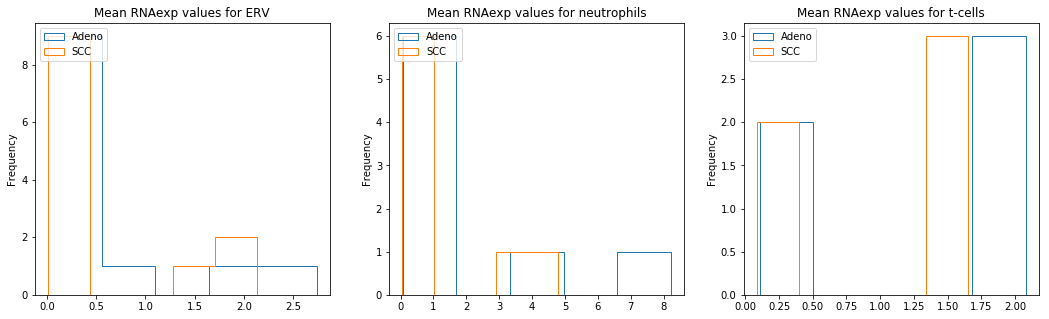

In [181]:
fig, ax = plt.subplots(ncols=3, figsize=(18,5))
df_erv['RNAex'].loc[df_erv['RNAex'].Diagnosis=='Lung Adenocarcinoma', erv_rna]\
                                                    .mean(axis=0).plot.hist(bins=5, histtype='step', ax=ax[0], label='Adeno')
df_erv['RNAex'].loc[df_erv['RNAex'].Diagnosis=='Lung Squamous Cell Carcinoma', erv_rna]\
                                                    .mean(axis=0).plot.hist(bins=5, histtype='step', ax=ax[0], label='SCC')

df_erv['RNAex'].loc[df_erv['RNAex'].Diagnosis=='Lung Adenocarcinoma', neutro_rna]\
                                                    .mean(axis=0).plot.hist(bins=5, histtype='step', ax=ax[1], label='Adeno')
df_erv['RNAex'].loc[df_erv['RNAex'].Diagnosis=='Lung Squamous Cell Carcinoma', neutro_rna]\
                                                    .mean(axis=0).plot.hist(bins=5, histtype='step', ax=ax[1], label='SCC')

df_erv['RNAex'].loc[df_erv['RNAex'].Diagnosis=='Lung Adenocarcinoma', tcell_rna]\
                                                    .mean(axis=0).plot.hist(bins=5, histtype='step', ax=ax[2], label='Adeno')
df_erv['RNAex'].loc[df_erv['RNAex'].Diagnosis=='Lung Squamous Cell Carcinoma', tcell_rna]\
                                                    .mean(axis=0).plot.hist(bins=5, histtype='step', ax=ax[2], label='SCC')

ax[0].set_title('Mean RNAexp values for ERV')
ax[1].set_title('Mean RNAexp values for neutrophils')
ax[2].set_title('Mean RNAexp values for t-cells')
ax[0].legend(loc=2)
ax[1].legend(loc=2)
ax[2].legend(loc=2)

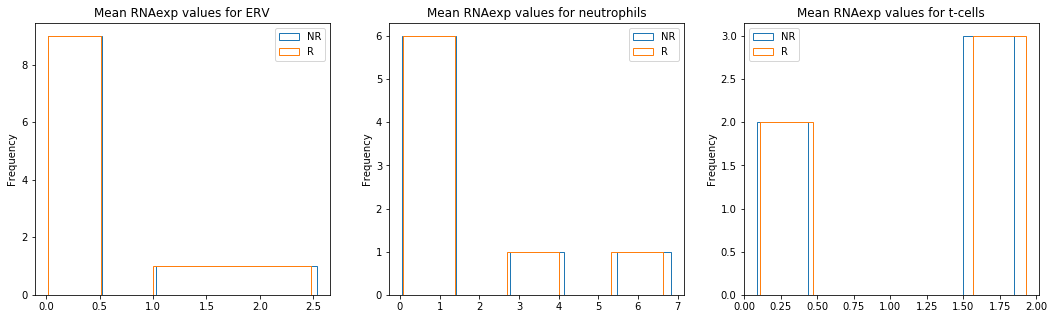

In [183]:
fig, ax = plt.subplots(ncols=3, figsize=(18,5))
df_erv['RNAex'].loc[df_erv['RNAex'].RTT==0, erv_rna]\
                                                    .mean(axis=0).plot.hist(bins=5, histtype='step', ax=ax[0], label='NR')
df_erv['RNAex'].loc[df_erv['RNAex'].RTT==1, erv_rna]\
                                                    .mean(axis=0).plot.hist(bins=5, histtype='step', ax=ax[0], label='R')

df_erv['RNAex'].loc[df_erv['RNAex'].RTT==0, neutro_rna]\
                                                    .mean(axis=0).plot.hist(bins=5, histtype='step', ax=ax[1], label='NR')
df_erv['RNAex'].loc[df_erv['RNAex'].RTT==1, neutro_rna]\
                                                    .mean(axis=0).plot.hist(bins=5, histtype='step', ax=ax[1], label='R')

df_erv['RNAex'].loc[df_erv['RNAex'].RTT==0, tcell_rna]\
                                                    .mean(axis=0).plot.hist(bins=5, histtype='step', ax=ax[2], label='NR')
df_erv['RNAex'].loc[df_erv['RNAex'].RTT==1, tcell_rna]\
                                                    .mean(axis=0).plot.hist(bins=5, histtype='step', ax=ax[2], label='R')

ax[0].set_title('Mean RNAexp values for ERV')
ax[1].set_title('Mean RNAexp values for neutrophils')
ax[2].set_title('Mean RNAexp values for t-cells')
ax[0].legend(loc=1)
ax[1].legend(loc=1)
ax[2].legend(loc=2)